## 0. Setup

In [ ]:
# basics
import re
import pandas as pd
import numpy as np
import argparse
import string
import nltk
from spellchecker import SpellChecker
from collections import Counter
 
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from matplotlib_venn import venn2
from sklearn.tree import plot_tree

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer, PunktSentenceTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.data import find
from sklearn.preprocessing import StandardScaler
from nltk.tag import pos_tag

# models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score

# Ignore convergence warnings
# we are ignoring it because our selected model is random forest and it does not have convergence issues
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [128]:
# load data
train_df = pd.read_csv('raw-dataset/train.csv')
test_df = pd.read_csv('raw-dataset/test.csv')

In [174]:
# Set seed for reproducibility
np.random.seed(1)

## 1. Exploratory Data Analysis

### 1.1 Basic Information

In [130]:
print(f"Shape of the training dataframe: {train_df.shape}")
print(f"Shape of the testing dataframe: {test_df.shape}")

Shape of the training dataframe: (1369, 6)
Shape of the testing dataframe: (587, 5)


In [131]:
print(f"Number of duplicates in the training data: {train_df.duplicated().sum()}")

Number of duplicates in the training data: 0


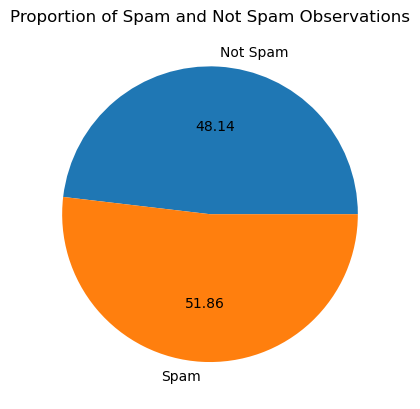

In [ ]:
# PIE PLOT Visualizing how many observations of each class training data has
# Calculate counts for each class
spam_count = train_df[train_df['CLASS'] == 1].shape[0]
not_spam_count = train_df[train_df['CLASS'] == 0].shape[0]

# Plot with correct labels
plt.pie([not_spam_count, spam_count], labels=['Not Spam', 'Spam'], autopct="%0.2f")
plt.title('Proportion of Spam and Not Spam Observations')
plt.show()

### 1.2 Date

In [133]:
# Check to see how observations with NA date are distributed
missing_dates_by_class = train_df.groupby('CLASS')['DATE'].apply(lambda x: x.isna().sum())
print("Missing Dates by Class:")
print(f"Not Spam: {missing_dates_by_class[0]}")
print(f"Spam: {missing_dates_by_class[1]}")

Missing Dates by Class:
Not Spam: 0
Spam: 170


### 1.3 Video and User Information

In [134]:
unique_users = train_df['AUTHOR'].nunique()
print(f"Number of unique users in the training data: {unique_users}")
unique_dates = train_df['DATE'].nunique()
print(f"Number of unique dates in the training data: {unique_dates}")

Number of unique users in the training data: 1267
Number of unique dates in the training data: 1199


### 1.4 Comment

#### 1.4.1 Character counts

Maximum number of characters in comments: 1200
Minimum number of characters in comments: 3
Mean number of characters in comments: 95.5989773557341
Mean number of characters in spam comments: 140.80845070422535
Mean number of characters in not spam comments: 46.8907435508346


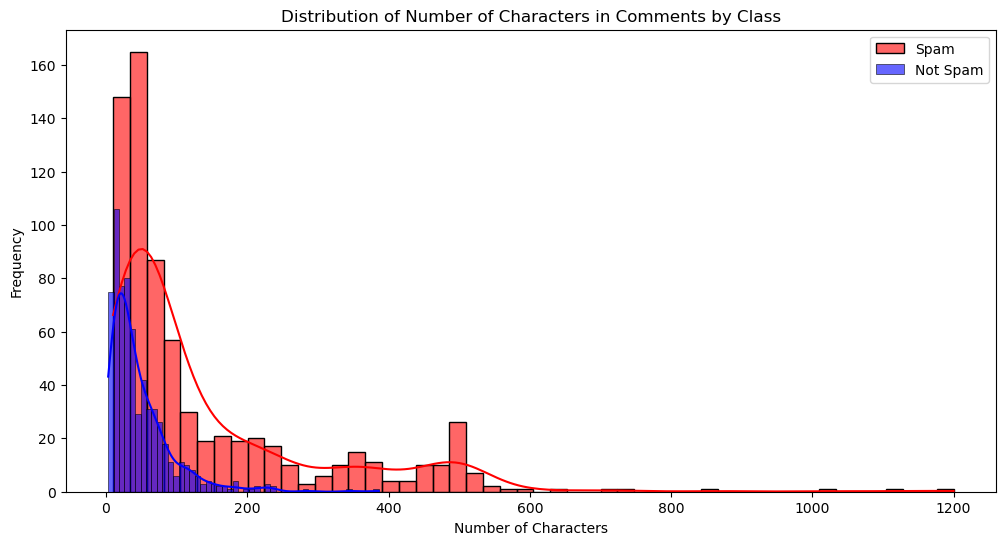

In [135]:
# check for number of characters in each comment
train_df['n_chars'] = train_df['CONTENT'].apply(len)
print(f"Maximum number of characters in comments: {train_df['n_chars'].max()}")
print(f"Minimum number of characters in comments: {train_df['n_chars'].min()}")
print(f"Mean number of characters in comments: {train_df['n_chars'].mean()}")

# check for number of characters based on class
spam_chars = train_df[train_df['CLASS'] == 1]['n_chars']
not_spam_chars = train_df[train_df['CLASS'] == 0]['n_chars']
print(f"Mean number of characters in spam comments: {spam_chars.mean()}")
print(f"Mean number of characters in not spam comments: {not_spam_chars.mean()}")

# Plot the distribution of the number of characters based on class
plt.figure(figsize=(12, 6))
sns.histplot(spam_chars, bins=50, kde=True, color='red', label='Spam', alpha=0.6)
sns.histplot(not_spam_chars, bins=50, kde=True, color='blue', label='Not Spam', alpha=0.6)
plt.title('Distribution of Number of Characters in Comments by Class')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()


#### 1.4.2 Word counts

In [136]:
# basic functions
def clean_text1(text):
    # Remove '\ufeff' if present
    text = text.replace('\ufeff', '')
    # Remove punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))
    # filter out stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

def clean_text2(text):
    text = text.replace('www', ' www ')
    text = text.replace('https', ' https ')
    text = text.replace('  ', ' ')
    return text

def tokenize(text):
    sentence_tokenizer = TreebankWordTokenizer()
    lemmatizer = WordNetLemmatizer()
    tokenized_text = sentence_tokenizer.tokenize(text.lower())
    final = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return final

def count_vect(text):
    return ' '.join(text)

def clean_text_eda(text):
    text = clean_text1(text)
    text = clean_text2(text)
    text = tokenize(text)
    return text

def token_to_string(tokens):
    text = ' '.join(tokens)
    text = text.replace('  ', ' ')
    return text

train_df['tokenized'] = train_df['CONTENT'].apply(clean_text_eda)
train_df['cleaned'] = train_df['tokenized'].apply(token_to_string)

Maximum number of words in comments: 99
Minimum number of words in comments: 0
Mean number of words in comments: 9.14463111760409
Mean number of words in spam comments: 13.03943661971831
Mean number of words in not spam comments: 4.948406676783004


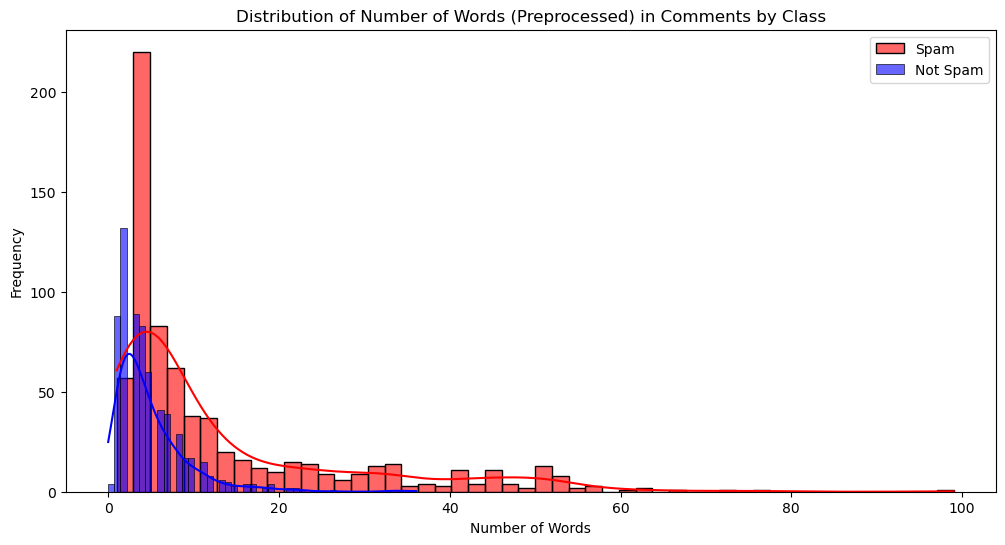

In [14]:
# Calculate the number of words in each comment
train_df['n_words'] = train_df['tokenized'].apply(len)
print(f"Maximum number of words in comments: {train_df['n_words'].max()}")
print(f"Minimum number of words in comments: {train_df['n_words'].min()}")
print(f"Mean number of words in comments: {train_df['n_words'].mean()}")

# Check for number of words based on class
spam_words = train_df[train_df['CLASS'] == 1]['n_words']
not_spam_words = train_df[train_df['CLASS'] == 0]['n_words']
print(f"Mean number of words in spam comments: {spam_words.mean()}")
print(f"Mean number of words in not spam comments: {not_spam_words.mean()}")

# Plot the distribution of the number of words based on class
plt.figure(figsize=(12, 6))
sns.histplot(spam_words, bins=50, kde=True, color='red', label='Spam', alpha=0.6)
sns.histplot(not_spam_words, bins=50, kde=True, color='blue', label='Not Spam', alpha=0.6)
plt.title('Distribution of Number of Words (Preprocessed) in Comments by Class')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### 1.4.3 Frequent words

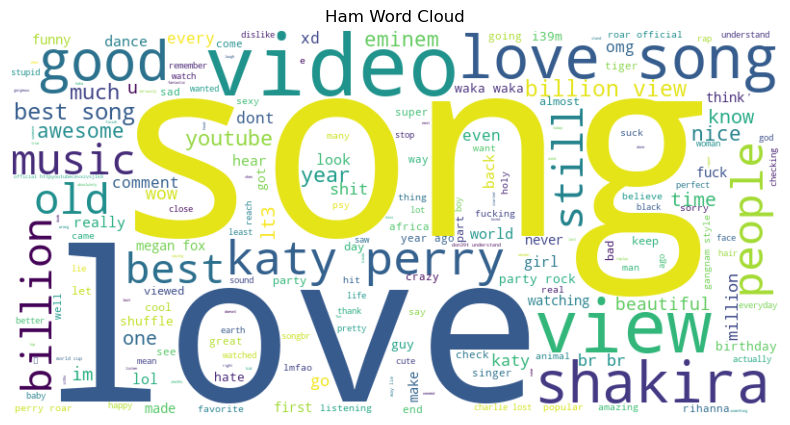

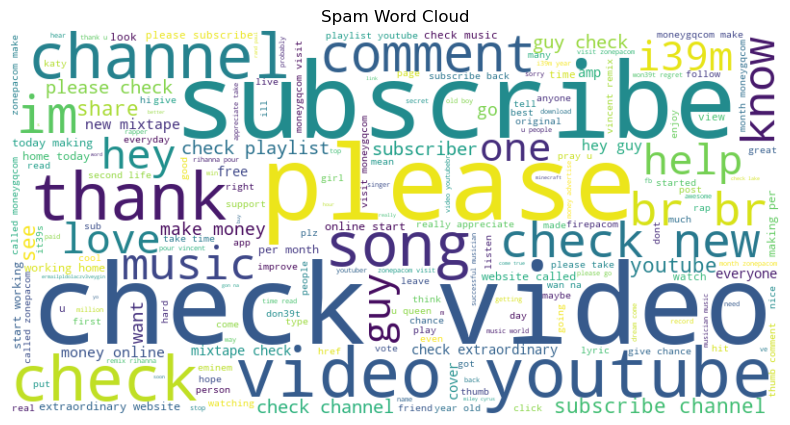

In [15]:
ham_wc = WordCloud(width=800, height=400, background_color='white').generate(train_df[train_df['CLASS'] == 0]['cleaned'].str.cat(sep=" "))
plt.figure(figsize=(10, 5))
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Ham Word Cloud")
plt.show()

spam_wc = WordCloud(width=800, height=400, background_color='white').generate(train_df[train_df['CLASS'] == 1]['cleaned'].str.cat(sep=" "))
plt.figure(figsize=(10, 5))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Spam Word Cloud")
plt.show()

In [20]:
# Filter rows for each class
class_0_words = ' '.join(train_df[train_df['CLASS'] == 0]['cleaned']).split()
class_1_words = ' '.join(train_df[train_df['CLASS'] == 1]['cleaned']).split()

# Word frequency
# Count word occurrences in each class
class_0_word_counts = Counter(class_0_words)
class_1_word_counts = Counter(class_1_words)

# Display the most common words in each class
print("Most common words in Not Spam comments:")
print(class_0_word_counts.most_common(10))
print("\nMost common words in Spam comments:")
print(class_1_word_counts.most_common(10))

Most common words in Not Spam comments:
[('song', 162), ('love', 104), ('view', 60), ('like', 60), ('video', 56), ('best', 42), ('billion', 40), ('katy', 38), ('2', 36), ('shakira', 32)]

Most common words in Spam comments:
[('check', 404), ('video', 198), ('please', 159), ('subscribe', 157), ('youtube', 137), ('channel', 126), ('like', 117), ('http', 111), ('music', 89), ('www', 85)]


In [22]:
# Find the most frequent words in each class that do not appear in the other class
class_0_only_words = {word: count for word, count in class_0_word_counts.items() if word not in class_1_word_counts}
class_1_only_words = {word: count for word, count in class_1_word_counts.items() if word not in class_0_word_counts}

# Get the top 10 unique words in each class
class_0_unique_top_10 = Counter(class_0_only_words).most_common(10)
class_1_unique_top_10 = Counter(class_1_only_words).most_common(10)

# Display the most frequent words unique to each class
print("\nMost frequent unique words in Not Spam comments:")
print(class_0_unique_top_10)

print("\nMost frequent unique words in Spam comments:")
print(class_1_unique_top_10)


Most frequent unique words in Not Spam comments:
[('xd', 11), ('fox', 10), ('megan', 9), ('fuck', 9), ('lost', 7), ('viewed', 7), ('charlie', 6), ('end', 6), ('official', 5), ('favorite', 5)]

Most frequent unique words in Spam comments:
[('cover', 41), ('moneygqcom', 33), ('home', 32), ('playlist', 30), ('website', 30), ('working', 30), ('online', 29), ('free', 28), ('mixtape', 28), ('zonepacom', 27)]


<Figure size 640x480 with 0 Axes>

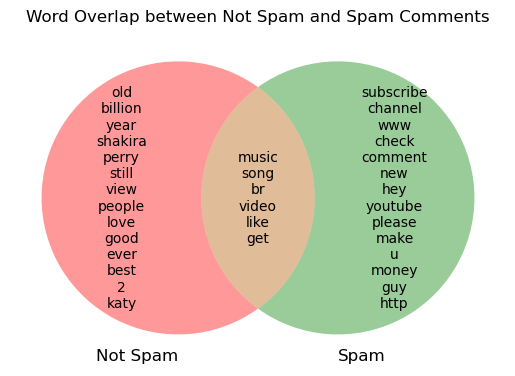

In [23]:
top_n = 20
class_0_top_words = {word for word, _ in class_0_word_counts.most_common(top_n)}
class_1_top_words = {word for word, _ in class_1_word_counts.most_common(top_n)}
# Find the overlapping and unique words
overlapping_words = class_0_top_words & class_1_top_words
class_0_unique_words = class_0_top_words - class_1_top_words
class_1_unique_words = class_1_top_words - class_0_top_words

plt.clf()
# Plot the Venn diagram of word overlap
overlap_fig, ax = plt.subplots()
venn = venn2(subsets=(len(class_0_unique_words), len(class_1_unique_words), len(overlapping_words)), set_labels=('Not Spam', 'Spam'))
venn.get_label_by_id('10').set_text('\n'.join(list(class_0_unique_words)))
venn.get_label_by_id('01').set_text('\n'.join(list(class_1_unique_words)))
venn.get_label_by_id('11').set_text('\n'.join(list(overlapping_words)))
plt.title("Word Overlap between Not Spam and Spam Comments")
plt.show()


#### 1.4.4 Typos and Emojis

In [24]:
spell = SpellChecker()
def find_typos(text):
    # Tokenize text and tag with parts of speech
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    # Only check words that aren't proper nouns (NNP or NNPS) or numbers
    typos = [
        word for word, pos in pos_tags 
        if word.lower() not in spell 
        and pos not in ('NNP', 'NNPS') 
        and not word.isdigit()
    ]
    
    # Join typos list if any, else return empty string
    return ', '.join(typos) if typos else ''


# Function to extract emojis from text
def find_emojis(text):
    # Regular expression pattern to match emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                           u"\U00002700-\U000027BF"  # Dingbats
                           u"\U000024C2-\U0001F251"  # Enclosed characters
                           "]+", flags=re.UNICODE)
    # Find all emojis in the text
    emojis = emoji_pattern.findall(text)
    # Join emojis list if any, else return empty string
    return ' '.join(emojis) if emojis else ''

# Create a table showing the top 10 typos in each class and their counts
def get_top_typos(class_typos):
    all_typos = ', '.join(class_typos).split(', ')
    typo_counts = Counter(all_typos)
    return typo_counts.most_common(10)

# Create a table showing the top 10 emojis in each class and their counts
def get_top_emojis(class_emojis):
    all_emojis = ' '.join(class_emojis).split()
    emoji_counts = Counter(all_emojis)
    return emoji_counts.most_common(11)

In [28]:
# Apply the emoji detection function
train_df['typos'] = train_df['cleaned'].apply(find_typos)
class_0_top_typos = get_top_typos(train_df[train_df['CLASS'] == 0]['typos'])
class_1_top_typos = get_top_typos(train_df[train_df['CLASS'] == 1]['typos'])
# Create a DataFrame to display the top typos in each class
top_typos_df = pd.DataFrame({
    'Not Spam Typos': [typo for typo, _ in class_0_top_typos],
    'Not Spam Counts': [count for _, count in class_0_top_typos],
    'Spam Typos': [typo for typo, _ in class_1_top_typos],
    'SpamCounts': [count for _, count in class_1_top_typos]
})
top_typos_df

,Not Spam Typos,Not Spam Counts,Spam Typos,SpamCounts
0,,291,youtube,137
1,katy,38,http,111
2,shakira,32,,109
3,br,23,www,85
4,youtube,18,br,70
5,eminem,16,im,48
6,waka,16,i39m,41
7,lt3,15,moneygqcom,33
8,im,14,playlist,30
9,www,12,mixtape,28


In [32]:
train_df['emojis'] = train_df['CONTENT'].apply(find_emojis)
class_0_top_emojis = get_top_emojis(train_df[train_df['CLASS'] == 0]['emojis'])
class_1_top_emojis = get_top_emojis(train_df[train_df['CLASS'] == 1]['emojis'])

# Create a DataFrame to display the top emojis in each class
top_emojis_df = pd.DataFrame({
    'Not Spam Emojis': [emoji for emoji, _ in class_0_top_emojis],
    'Not Spam Counts': [count for _, count in class_0_top_emojis],
    'Spam Emojis': [emoji for emoji, _ in class_1_top_emojis],
    'Spam Counts': [count for _, count in class_1_top_emojis]
})

# Skip the first row and show the next 10 rows
next_10_entries = top_emojis_df.iloc[1:11]

# Print the DataFrame with a title
print("Unique Emoji Clusters by Class")
next_10_entries

Unique Emoji Clusters by Class


,Not Spam Emojis,Not Spam Counts,Spam Emojis,Spam Counts
1,💜﻿,2,❥,2
2,▲,2,▬▬▬▬▬▬▬▬▬▬,2
3,▬▬▬▬▬▬▬▬▬▬,2,▬▬▬▬▬▬▬▬,2
4,⤴︎⤴︎﻿,1,😊,1
5,강남스타일,1,⛺🏤⛺⛺﻿,1
6,♥♥♥♥♥♥﻿,1,❤️﻿,1
7,♥﻿,1,👍﻿,1
8,❤﻿,1,👀﻿,1
9,😂﻿,1,😅﻿,1
10,😀😘﻿,1,♥﻿,1


In [ ]:
# Total number of entries in train_df for each class
total_entries_class_0 = len(train_df[train_df['CLASS'] == 0])
total_entries_class_1 = len(train_df[train_df['CLASS'] == 1])

# Count of no-emoji entries (from the first row of the table)
no_emoji_class_0_count = top_emojis_df.iloc[0]["Not Spam Counts"]
no_emoji_class_1_count = top_emojis_df.iloc[0]["Spam Counts"]

# Calculate the percentage of no-emoji entries
class_0_no_emoji_percentage = (no_emoji_class_0_count / total_entries_class_0) * 100
class_1_no_emoji_percentage = (no_emoji_class_1_count / total_entries_class_1) * 100

# Print the results inline
print("Entries With no Emojis by Class (Percentage of Total Entries):")
print(f"Not Spam: {class_0_no_emoji_percentage:.2f}%")
print(f"Spam: {class_1_no_emoji_percentage:.2f}%")

Entries With no Emojis by Class (Percentage of Total Entries):
Not Spam: 89.07%
Spam: 66.48%


## 2. Data Preprocessing

### 2.0 Setup

In [152]:
train_df = pd.read_csv('raw-dataset/train.csv')
test_df = pd.read_csv('raw-dataset/test.csv')

### 2.1 Feature Engineering

In [153]:
# date column into binary
train_df['DATE'] = train_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)
test_df['DATE'] = test_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)

### 2.2 Comment Preprocessing

In [177]:
# basic functions
def remove_punctuations_stop_words(text):
    # Remove '\ufeff' if present
    text = text.replace('\ufeff', '')
    # Remove punctuation from the text
    punctuation = string.punctuation.replace("'", "")
    text = text.translate(str.maketrans('', '', punctuation))
    # filter out stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

def identify_web_related_terms(text):
    text = text.replace('www', ' www ')
    text = text.replace('https', ' https ')
    text = text.replace('  ', ' ')
    return text

def tokenize(text):
    sentence_tokenizer = TreebankWordTokenizer()
    lemmatizer = WordNetLemmatizer()
    tokenized_text = sentence_tokenizer.tokenize(text.lower())
    final = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return final

def join_tokens(text):
    return ' '.join(text)

def clean_text(text):
    text = remove_punctuations_stop_words(text)
    text = identify_web_related_terms(text)
    text = tokenize(text)
    return join_tokens(text)

In [155]:
train_df['cleaned_text'] = train_df['CONTENT'].apply(clean_text)
test_df['cleaned_text'] = test_df['CONTENT'].apply(clean_text)

### 2.3 Word Vectorization: TF-IDF Vectorizer

In [ ]:
tf_vectorizer = TfidfVectorizer()
x_1 = tf_vectorizer.fit_transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x = np.hstack((x_1, x_2))
y = train_df['CLASS']

## 3. Model Development and Training

### 3.1 Linear Separability: Principal Component Analysis

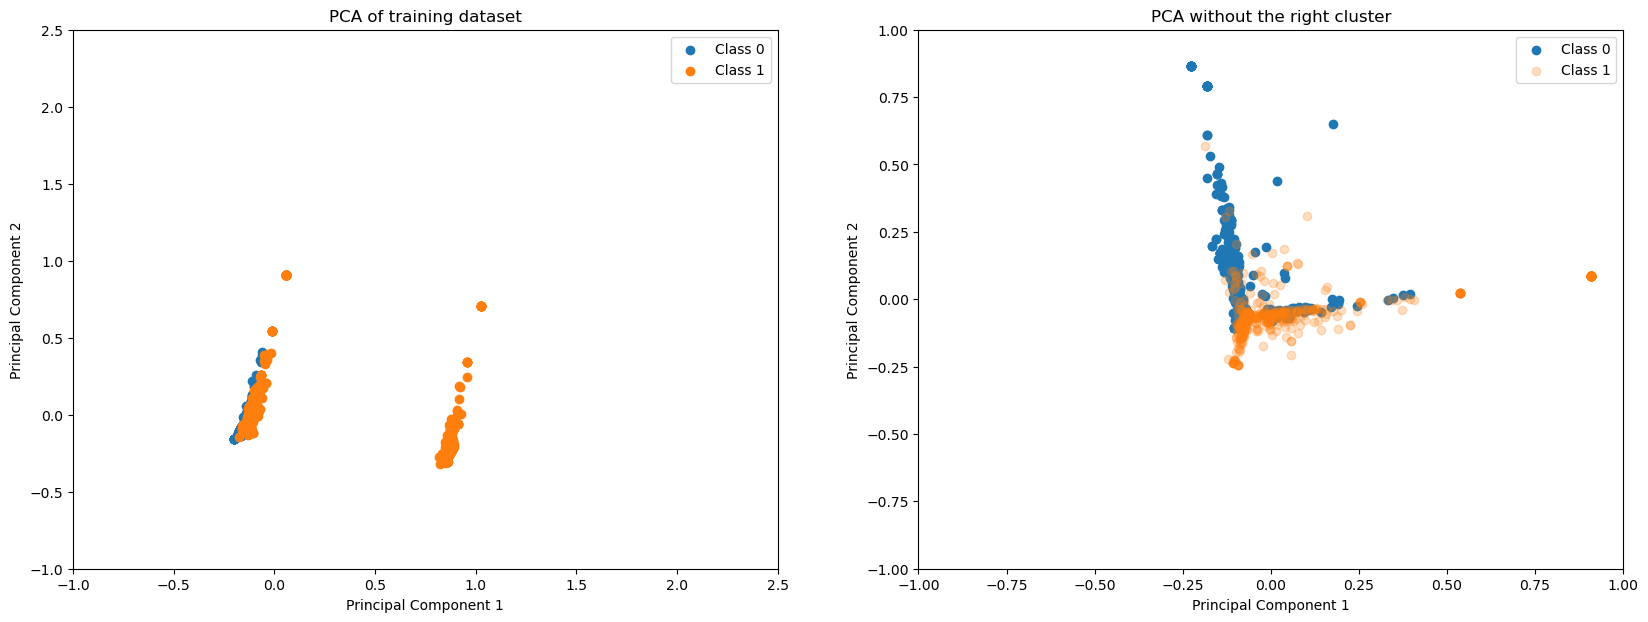

In [163]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# PCA for tf_idf
pca_tf_idf = PCA(n_components=2)
x_pca_tf_idf = pca_tf_idf.fit_transform(x)

# Plot for tf_idf
axes[0].set_title('PCA of training dataset')
for class_value in np.unique(y):
    axes[0].scatter(x_pca_tf_idf[y == class_value, 0], x_pca_tf_idf[y == class_value, 1], label=f'Class {class_value}')
axes[0].set_xlim(-1, 2.5)
axes[0].set_ylim(-1, 2.5)
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend()

# Filtered PCA for tf_idf
right_cluster_threshold = 0.5

pca_tf_idf_temp = PCA(n_components=2)
x_pca_temp = pca_tf_idf_temp.fit_transform(x_tf_idf)

left_cluster_mask = x_pca_temp[:, 0] < right_cluster_threshold
x_tf_idf_left_cluster = x_tf_idf[left_cluster_mask]
y_left_cluster = y[left_cluster_mask]

pca_tf_idf_filtered = PCA(n_components=2)
x_pca_filtered = pca_tf_idf_filtered.fit_transform(x_tf_idf_left_cluster)

axes[1].set_title('PCA without the right cluster')
for class_value in np.unique(y_left_cluster):
    if class_value == 1:
        # Make Class 1 semi-transparent
        axes[1].scatter(x_pca_filtered[y_left_cluster == class_value, 0],
                        x_pca_filtered[y_left_cluster == class_value, 1],
                        label=f'Class {class_value}', alpha=0.25)
    else:
        # Class 0 remains opaque
        axes[1].scatter(x_pca_filtered[y_left_cluster == class_value, 0],
                        x_pca_filtered[y_left_cluster == class_value, 1],
                        label=f'Class {class_value}', alpha=1)

axes[1].set_xlim(-1, 1)
axes[1].set_ylim(-1, 1)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].legend()

plt.show()

### 3.2 Linear Separability: Hard Margin Support Vector Machine

In [167]:
x_train, x_test, y_train, y_test = train_test_split(x_tf_idf, y, test_size=0.2, random_state=42)

In [168]:
# tf_idf
hard_margin_svm = SVC(kernel='linear', C=100000000000)

hard_margin_svm.fit(x_train, y_train)
y_pred = hard_margin_svm.predict(x_test)

hard_margin_svm_accuracy_score = accuracy_score(y_test, y_pred)
hard_margin_svm_accuracy_score

0.9233576642335767

### 3.3 Model Hyperparameter Tuning

In [53]:
lr_model = LogisticRegression()

param_grid = {
    'C': [100, 500, 1000],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 1000, 3000]
}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_lr.fit(x_t_train, y_t_train)
grid_search_lr.best_params_

{'C': 1000, 'max_iter': 100, 'solver': 'lbfgs'}

In [55]:
svm = SVC()

param_svm_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']

}
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_svm_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(x_t_train, y_t_train)
grid_search_svm.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [171]:
rf = RandomForestClassifier(random_state=42)

param_rf_grid = {
    'max_depth': [50, 100, 150, None],
    'min_samples_split': [2, 4, 5, 6, 7, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_random_forest = GridSearchCV(estimator=rf, param_grid=param_rf_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_random_forest.fit(x_t_train, y_t_train)
grid_search_random_forest.best_params_

{'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 5}

### 3.4 Model Comparison

In [173]:
lr_best_model = grid_search_lr.best_estimator_
svm_best_model = grid_search_svm.best_estimator_
rf_best_model = grid_search_random_forest.best_estimator_

In [114]:
print('SVC:', svc_tv_scores.mean())
print('LR:', t_grid_search.best_score_)
print('RF:', grid_search_random_forest.best_score_)

SVC: 0.9214611872146119
LR: 0.9360730593607306
RF: 0.9461187214611873


## 4. Model Evaluation

### 4.1 Sample Tree Visualization

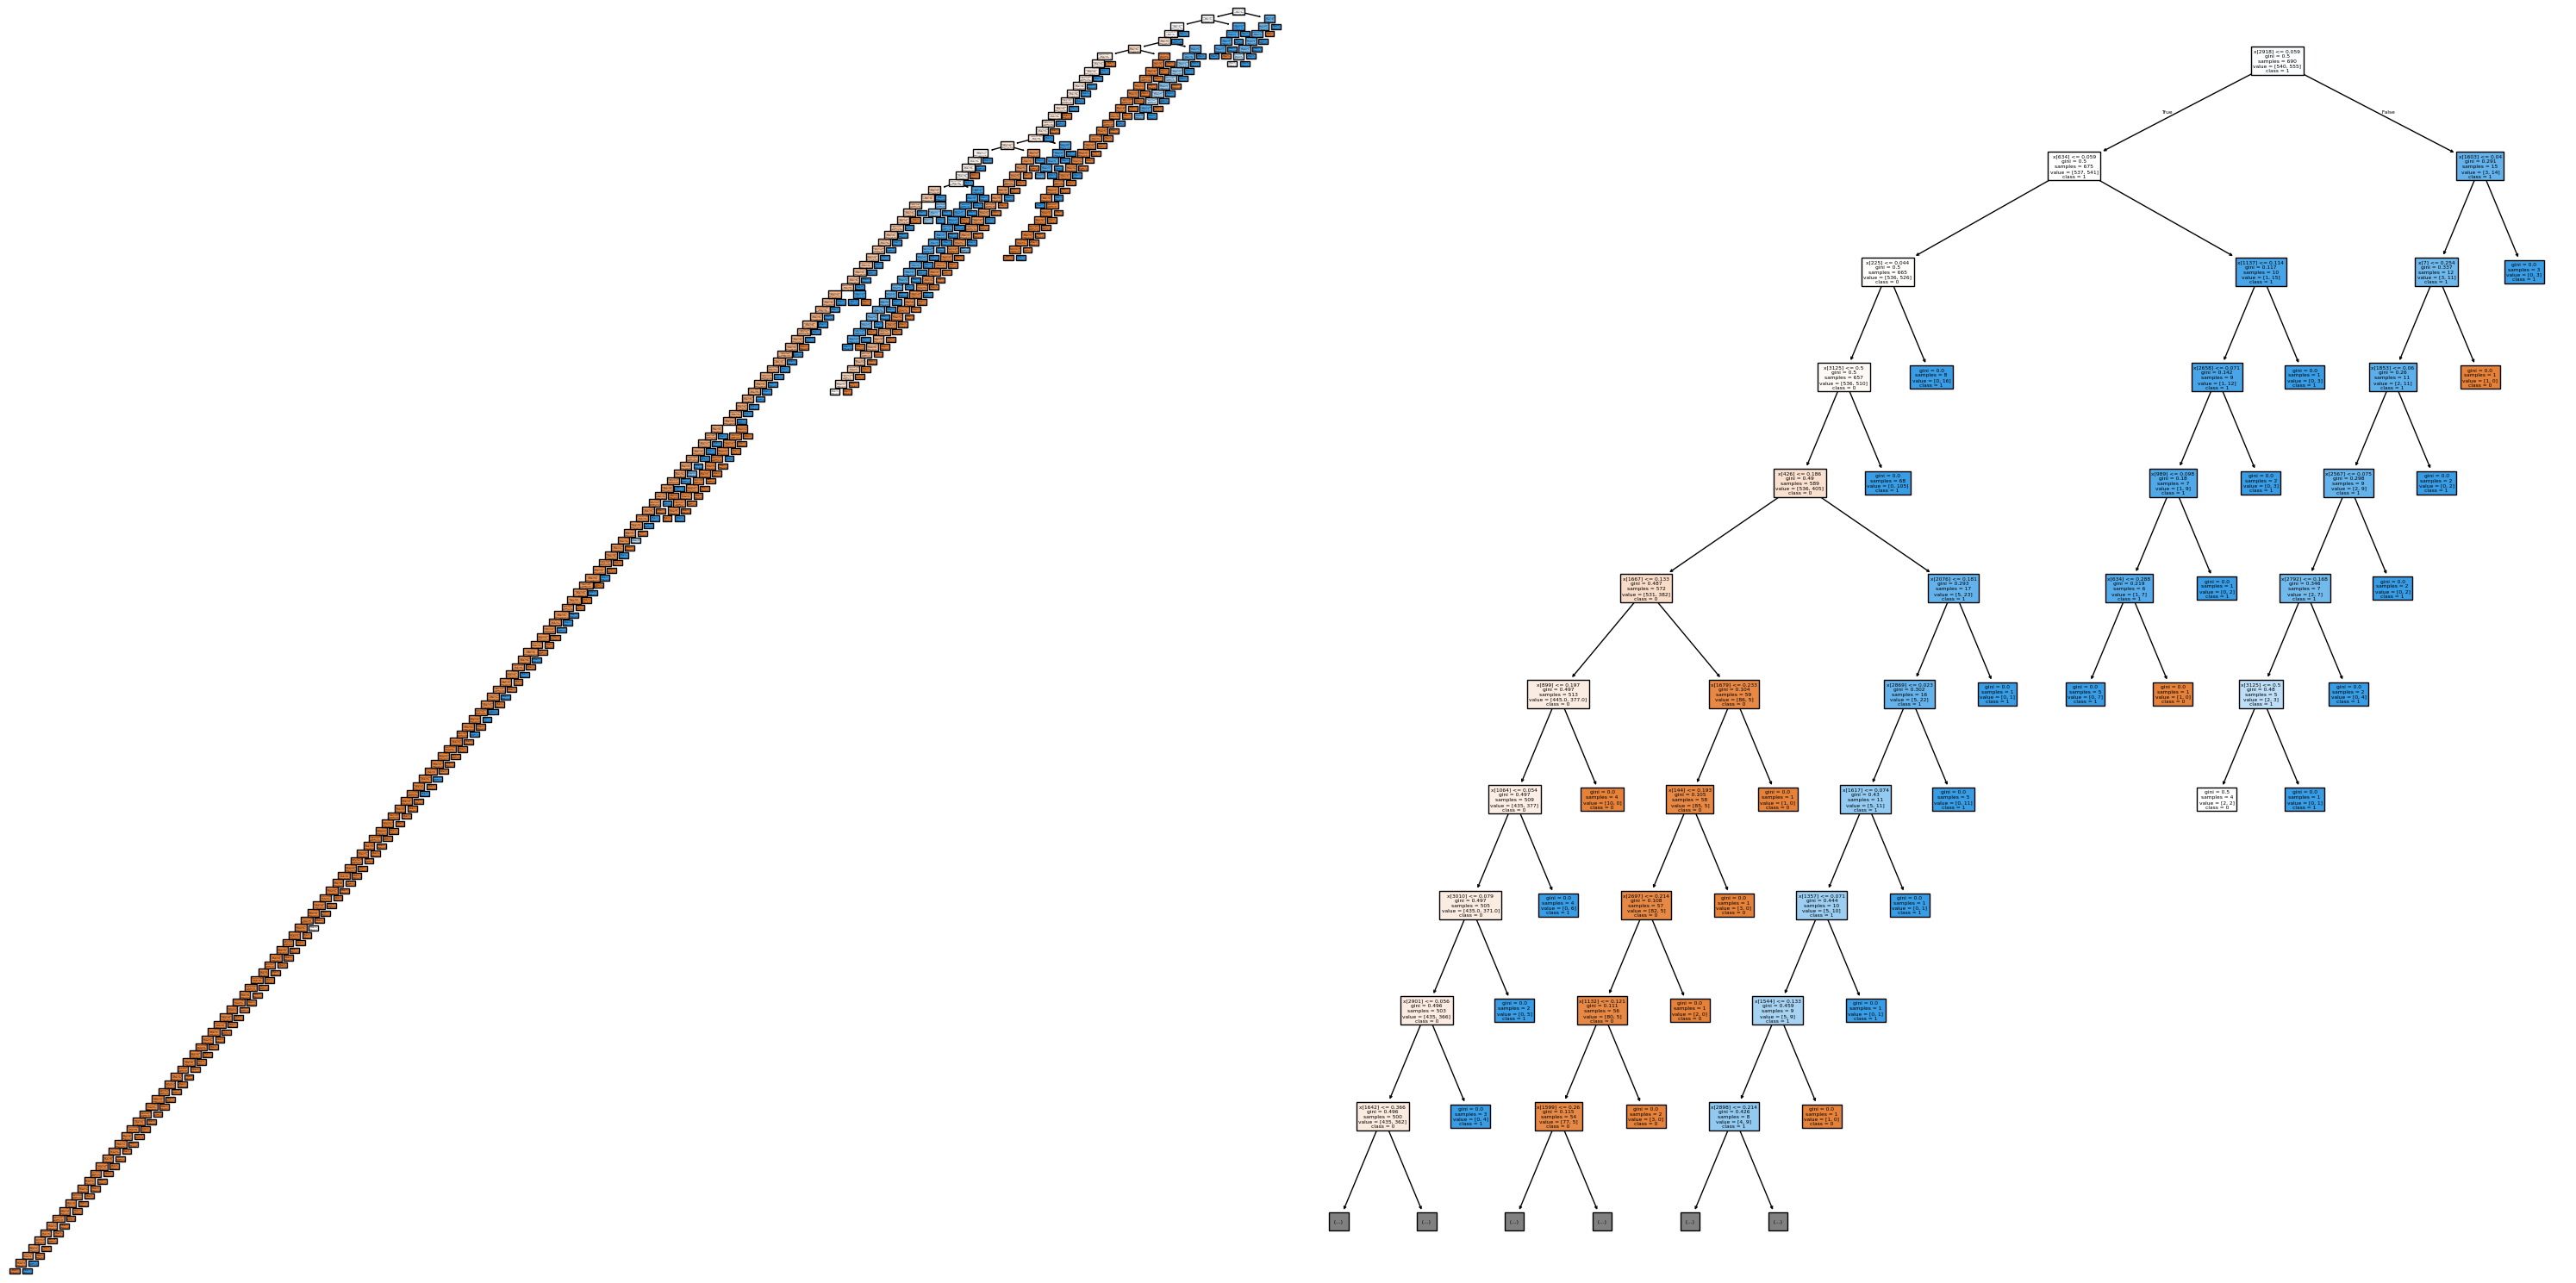

In [115]:
rf_best_model = grid_search_random_forest.best_estimator_
sample_tree = best_model.estimators_[0]

fig, axes = plt.subplots(1, 2, figsize=(30, 15))

# Plot the full tree on the left, zoomed-in on the right
axes[0].set_title('Full Decision Tree')
plot_tree(sample_tree, filled=True, class_names=['0', '1'], ax=axes[0])
axes[1].set_title('Zoomed-In Decision Tree')
plot_tree(sample_tree, max_depth=10, filled=True, class_names=['0', '1'], ax=axes[1])

plt.tight_layout()
plt.show()

### 4.2 Influential Features

In [116]:
def get_top_n_features(model, feature_names, n):
    # Get feature importances
    importances = model.feature_importances_
    
    # Get indices of the top n features
    indices = np.argsort(importances)[-n:][::-1]
    
    # Get the feature names and their importances, handling the special case for index 3125
    top_features = []
    for i in indices:
        feature_name = "DATE_NA" if i == 3125 else feature_names[i]
        top_features.append((feature_name, importances[i]))
    
    return top_features

feature_names = tf_vectorizer.get_feature_names_out()
top_20_features = get_top_n_features(rf_t, feature_names, 20)
print(f"Top 20 features with Gini scores:")
for feature in top_20_features:
    print(feature)

Top 20 features with Gini scores:
('check', 0.15020740132851237)
('subscribe', 0.06403910429987239)
('http', 0.04644956986804338)
('please', 0.039549166974305355)
('channel', 0.037150059501690966)
('DATE_NA', 0.035813543695964796)
('video', 0.0306014779049702)
('youtube', 0.028121026082329015)
('www', 0.02801516477170082)
('song', 0.017273069297097095)
('love', 0.012762740702923214)
('playlist', 0.010584143945496479)
('subscriber', 0.010334913926165567)
('new', 0.008791664719276802)
('view', 0.008603208232681325)
('share', 0.007428947927377982)
('shakira', 0.007213550583973871)
('follow', 0.007086967178583597)
('money', 0.006367456312771222)
('comment', 0.006217017061528583)


### 4.3 Metrics Evaluation

### 4.3.1 Logistic Regression

Validation Accuracy: 0.9161
Recall: 0.8966
Precision: 0.9420
False Negative Rate (FNR): 0.10344827586206896
False Positive Rate (FPR): 0.06201550387596899


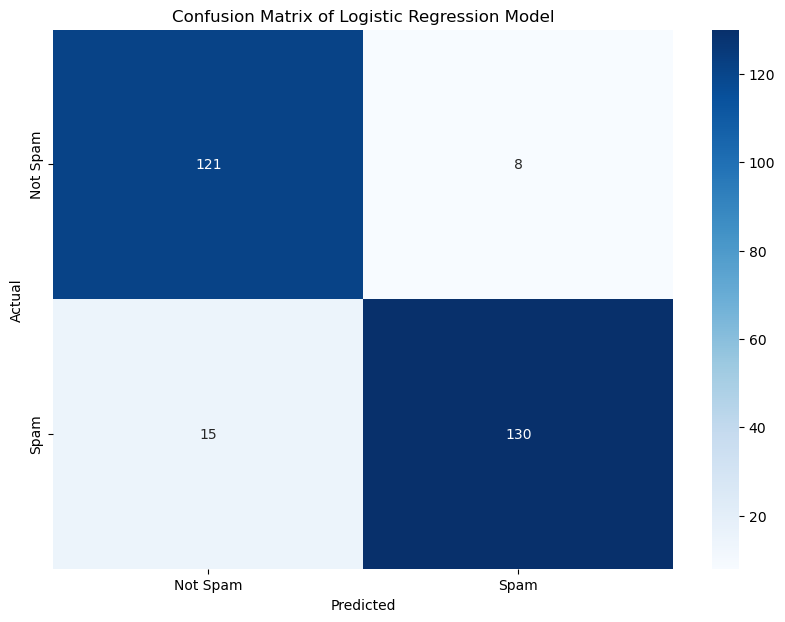

In [117]:
best_lr_model = grid_search_lr.best_estimator_
y_val_pred = best_lr_model.predict(x_t_test)
val_accuracy = accuracy_score(y_t_test, y_val_pred)
recall = recall_score(y_t_test, y_val_pred)
precision = precision_score(y_t_test, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

conf_matrix = confusion_matrix(y_t_test, y_val_pred)

TN, FP, FN, TP = conf_matrix.ravel()

# Calculate FNR and FPR
FNR = FN / (FN + TP)
FPR = FP / (FP + TN)

print(f"False Negative Rate (FNR): {FNR}")
print(f"False Positive Rate (FPR): {FPR}")

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Logistic Regression Model')
plt.show()

### 4.3.2 Support Vector Machine

Test Accuracy: 0.9124087591240876
Recall: 0.8827586206896552
Precision: 0.9481481481481482
False Negative Rate (FNR): 0.11724137931034483
False Positive Rate (FPR): 0.05426356589147287


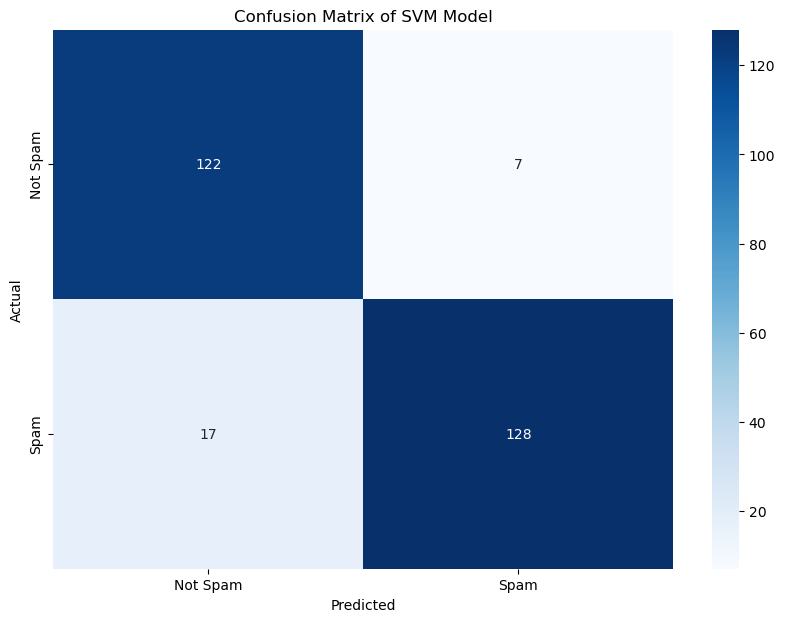

In [118]:
best_svm_model = grid_search_svm.best_estimator_
y_val_pred = best_svm_model.predict(x_t_test)
val_accuracy = accuracy_score(y_t_test, y_val_pred)
recall = recall_score(y_t_test, y_val_pred)
precision = precision_score(y_t_test, y_val_pred)
print(f"Test Accuracy: {val_accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

conf_matrix = confusion_matrix(y_t_test, y_val_pred)

TN, FP, FN, TP = conf_matrix.ravel()

# Calculate FNR and FPR
FNR = FN / (FN + TP)
FPR = FP / (FP + TN)

print(f"False Negative Rate (FNR): {FNR}")
print(f"False Positive Rate (FPR): {FPR}")

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of SVM Model')
plt.show()

### 4.3.3 Random Forest

Test Accuracy: 0.9416058394160584
Recall: 0.9172413793103448
Precision: 0.9708029197080292
False Negative Rate (FNR): 0.08275862068965517
False Positive Rate (FPR): 0.031007751937984496


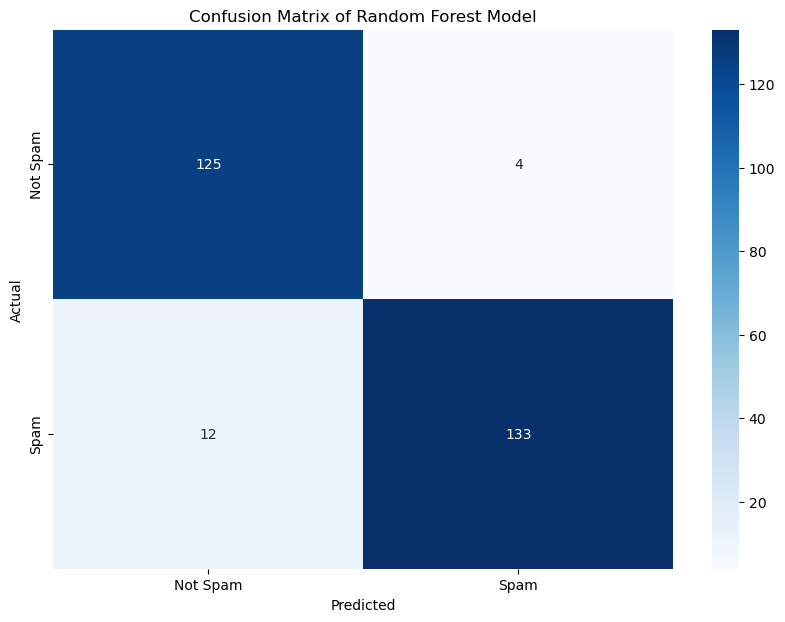

In [175]:
best_model_rf = grid_search_random_forest.best_estimator_
y_val_pred = best_model_rf.predict(x_t_test)
val_accuracy = accuracy_score(y_t_test, y_val_pred)
recall = recall_score(y_t_test, y_val_pred)
precision = precision_score(y_t_test, y_val_pred)
print(f"Test Accuracy: {val_accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

conf_matrix = confusion_matrix(y_t_test, y_val_pred)

TN, FP, FN, TP = conf_matrix.ravel()

# Calculate FNR and FPR
FNR = FN / (FN + TP)
FPR = FP / (FP + TN)

print(f"False Negative Rate (FNR): {FNR}")
print(f"False Positive Rate (FPR): {FPR}")

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Random Forest Model')
plt.show()

## 5. Final Prediction 

In [120]:
test_df['cleaned_text'] = test_df['CONTENT'].apply(clean_text)
test_df['DATE'] = test_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)
tf_vectorizer = TfidfVectorizer()
tf_vectorizer.fit(list(train_df['cleaned_text']))

x_1 = tf_vectorizer.transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x = np.hstack((x_1, x_2))
y = train_df['CLASS']

x_test_1 = tf_vectorizer.transform(list(test_df['cleaned_text'])).toarray()
x_test_2 = np.array(test_df['DATE']).reshape(-1, 1)
x_test = np.hstack((x_test_1, x_test_2))

In [121]:
best_params_final = best_model.get_params()
best_params_final

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [122]:
rf = RandomForestClassifier(**best_params_final)
rf.fit(x, y)

RandomForestClassifier(min_samples_split=5)

In [123]:
y_pred = rf.predict(x_test)

In [124]:
sol = pd.read_csv("./sample_submission.csv")
sol['CLASS'] = y_pred
sol.head()
sol.to_csv("final_submission_dec_2.csv", index=False)

In [125]:
sample_str = "Great amazing song video by shakira! This reminds me of a site where I found similar amazing content follow me for more"
sample_cleaned = clean_text(sample_str)
sample_vectorized = tf_vectorizer.transform([sample_cleaned]).toarray()
sample_date = np.array([0]).reshape(-1, 1)
sample_x = np.hstack((sample_vectorized, sample_date))

prediction = best_model.predict(sample_x)
print(f"COMMENT: {sample_str}")
if prediction[0] == 0:
    print("Not Spam")
else:
    print("Spam")

COMMENT: Great amazing song video by shakira! This reminds me of a site where I found similar amazing content follow me for more
Not Spam
